In [1]:
#!pip install lightgbm --upgrade

In [19]:
# %matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pickle
import imblearn
import plotly.graph_objs as go
import optuna
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import optuna.integration.lightgbm as lgb
import lightgbm
from lightgbm import early_stopping
from lightgbm import log_evaluation
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
#Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2

pd.options.display.float_format = '{:,.3}'.format

In [3]:
data = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')
data

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [4]:
data.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [5]:
category_cols = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education','Income']

binary_cols = ['Diabetes_binary','HighBP', 'HighChol', 'CholCheck',  'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost','DiffWalk', 'Sex']
stats_cols = ['BMI','GenHlth','MentHlth','PhysHlth','Age','Education','Income']
cat_all = category_cols.copy()

In [6]:
scaler = MinMaxScaler()
df_filtered = data[binary_cols + stats_cols]
df_normalized = pd.DataFrame(scaler.fit_transform(df_filtered[stats_cols]), columns=stats_cols)
df_combined = pd.concat([data[binary_cols], df_normalized], axis=1)

mean_diabetes = df_combined[df_combined['Diabetes_binary'] == 1].mean()[1:]
mean_nondiabetes = df_combined[df_combined['Diabetes_binary'] == 0].mean()[1:]

According to the radar plot, people with diabetes:
   - had stroke
   - smoke more often
   - have higher level of cholestrol
   - have higher blood pressure
   - have lower income
   - have lower education level
   - are older
   - have higher BMI
   - have difficulty to walk
   - have lower level of GenHlth, MentHlth, and PhysHlth

## Train-Test Split

In [7]:
#ID_col = null
target = 'Diabetes_binary'
train, test = train_test_split(data)

X_train = train.drop(columns=[target]).copy()
X_test = test.drop(columns=[target]).copy()

y_train = train['Diabetes_binary'].copy()
y_test = test['Diabetes_binary'].copy()

In [8]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [9]:
models = [#DecisionTreeClassifier(),RandomForestClassifier(),SVC(),
          LogisticRegression(),XGBClassifier(),LGBMClassifier()]
scoring = ['accuracy','f1','precision','recall']
models_columns = ['Name','fit_time','test_accuracy','train_accuracy',
                  'test_f1','train_f1','test_precision','train_precision',
                 'test_recall','train_recall']
models_chart = pd.DataFrame(columns = models_columns)

In [10]:
row_index = 0
for model in models:
    model_name = model.__class__.__name__
    models_chart.loc[row_index,'Name'] = model_name
    
    cv_results = cross_validate(model,X_train,y_train,cv =3,scoring = scoring,return_train_score = True,n_jobs=-1)
    models_chart.loc[row_index,'fit_time'] = cv_results['fit_time'].mean()
    models_chart.loc[row_index,'test_accuracy'] = cv_results['test_accuracy'].mean()
    models_chart.loc[row_index,'train_accuracy'] = cv_results['train_accuracy'].mean()
    models_chart.loc[row_index,'test_f1'] = cv_results[ 'test_f1'].mean()
    models_chart.loc[row_index,'train_f1'] = cv_results['train_f1'].mean()
    models_chart.loc[row_index,'test_precision'] = cv_results['test_precision'].mean()
    models_chart.loc[row_index,'train_precision'] = cv_results['train_precision'].mean()
    models_chart.loc[row_index,'test_recall'] = cv_results['test_recall'].mean()
    models_chart.loc[row_index,'train_recall'] = cv_results['train_recall'].mean()
    
    row_index +=1

In [11]:
models_chart.sort_values(by='test_accuracy',ascending = False)

,Name,fit_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
1,XGBClassifier,22.8,0.898,0.93,0.872,0.926,0.965,0.964,0.834,0.892
2,LGBMClassifier,2.42,0.895,0.925,0.868,0.921,0.961,0.955,0.831,0.889
0,LogisticRegression,2.34,0.75,0.75,0.757,0.757,0.736,0.736,0.779,0.78


We applied oversampling and the result accuracy, f1, precision, and recall are all better off.

Fit the three models

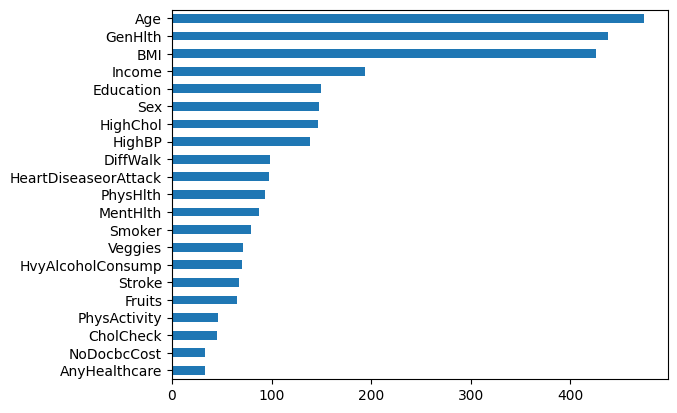

In [12]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
lr = LogisticRegression()
lr.fit(X_train,y_train)
#plot the graph of feature importances of lgbm
feature_importances = pd.Series(lgbm.feature_importances_, index=X_train.columns)
sorted_importances = feature_importances.sort_values(ascending= True)
sorted_importances.plot(kind='barh')
plt.show()

In [14]:
# hyperparamter tuning
import sklearn.datasets

dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

lgbm_tuned = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[early_stopping(100), log_evaluation(100)],
)

[I 2023-02-25 21:43:43,249] A new study created in memory with name: no-name-ff5600ff-4bad-425a-a277-c464c4bcc5ae
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.193695	valid_1's binary_logloss: 0.313828
[200]	valid_0's binary_logloss: 0.183919	valid_1's binary_logloss: 0.311074
[300]	valid_0's binary_logloss: 0.180459	valid_1's binary_logloss: 0.31078
[400]	valid_0's binary_logloss: 0.177749	valid_1's binary_logloss: 0.310906


feature_fraction, val_score: 0.310748:  14%|######4                                      | 1/7 [00:05<00:32,  5.37s/it]

Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.179921	valid_1's binary_logloss: 0.310748
[100]	valid_0's binary_logloss: 0.19384	valid_1's binary_logloss: 0.314314
[200]	valid_0's binary_logloss: 0.183806	valid_1's binary_logloss: 0.312266
[300]	valid_0's binary_logloss: 0.178763	valid_1's binary_logloss: 0.31229


feature_fraction, val_score: 0.310748:  29%|############8                                | 2/7 [00:09<00:23,  4.68s/it]

[400]	valid_0's binary_logloss: 0.174557	valid_1's binary_logloss: 0.312228
Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.179921	valid_1's binary_logloss: 0.310748
[100]	valid_0's binary_logloss: 0.193048	valid_1's binary_logloss: 0.313631
[200]	valid_0's binary_logloss: 0.183702	valid_1's binary_logloss: 0.311593
[300]	valid_0's binary_logloss: 0.179164	valid_1's binary_logloss: 0.311497
[400]	valid_0's binary_logloss: 0.17549	valid_1's binary_logloss: 0.311551
Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.179921	valid_1's binary_logloss: 0.310748


feature_fraction, val_score: 0.310748:  43%|###################2                         | 3/7 [00:14<00:19,  4.79s/it]

[100]	valid_0's binary_logloss: 0.193703	valid_1's binary_logloss: 0.314228
[200]	valid_0's binary_logloss: 0.183725	valid_1's binary_logloss: 0.312063
[300]	valid_0's binary_logloss: 0.178773	valid_1's binary_logloss: 0.311943
[400]	valid_0's binary_logloss: 0.174832	valid_1's binary_logloss: 0.312167
Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.179921	valid_1's binary_logloss: 0.310748


feature_fraction, val_score: 0.310748:  57%|#########################7                   | 4/7 [00:19<00:14,  4.86s/it]

[100]	valid_0's binary_logloss: 0.193449	valid_1's binary_logloss: 0.313779
[200]	valid_0's binary_logloss: 0.183711	valid_1's binary_logloss: 0.311246
[300]	valid_0's binary_logloss: 0.17974	valid_1's binary_logloss: 0.31109
[400]	valid_0's binary_logloss: 0.176515	valid_1's binary_logloss: 0.311162


feature_fraction, val_score: 0.310748:  71%|################################1            | 5/7 [00:25<00:10,  5.16s/it]

Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.179921	valid_1's binary_logloss: 0.310748
[100]	valid_0's binary_logloss: 0.193384	valid_1's binary_logloss: 0.314169
[200]	valid_0's binary_logloss: 0.183598	valid_1's binary_logloss: 0.312048
[300]	valid_0's binary_logloss: 0.178842	valid_1's binary_logloss: 0.311843
[400]	valid_0's binary_logloss: 0.1747	valid_1's binary_logloss: 0.311912
Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.179921	valid_1's binary_logloss: 0.310748


feature_fraction, val_score: 0.310748:  86%|######################################5      | 6/7 [00:30<00:05,  5.21s/it]

[100]	valid_0's binary_logloss: 0.193113	valid_1's binary_logloss: 0.313829
[200]	valid_0's binary_logloss: 0.184	valid_1's binary_logloss: 0.311816
[300]	valid_0's binary_logloss: 0.179515	valid_1's binary_logloss: 0.311688
[400]	valid_0's binary_logloss: 0.175461	valid_1's binary_logloss: 0.311823
Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.179921	valid_1's binary_logloss: 0.310748


num_leaves, val_score: 0.310748:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.184249	valid_1's binary_logloss: 0.311479
[200]	valid_0's binary_logloss: 0.174829	valid_1's binary_logloss: 0.310776


num_leaves, val_score: 0.310715:   5%|##5                                               | 1/20 [00:04<01:22,  4.35s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.177223	valid_1's binary_logloss: 0.310715
[100]	valid_0's binary_logloss: 0.187307	valid_1's binary_logloss: 0.311778
[200]	valid_0's binary_logloss: 0.178258	valid_1's binary_logloss: 0.310759


num_leaves, val_score: 0.310715:  10%|#####                                             | 2/20 [00:08<01:14,  4.14s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.177223	valid_1's binary_logloss: 0.310715
[100]	valid_0's binary_logloss: 0.193292	valid_1's binary_logloss: 0.313587
[200]	valid_0's binary_logloss: 0.183516	valid_1's binary_logloss: 0.31093


num_leaves, val_score: 0.310715:  15%|#######5                                          | 3/20 [00:11<01:05,  3.83s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.177223	valid_1's binary_logloss: 0.310715
[100]	valid_0's binary_logloss: 0.186636	valid_1's binary_logloss: 0.311589
[200]	valid_0's binary_logloss: 0.17767	valid_1's binary_logloss: 0.310899


num_leaves, val_score: 0.310715:  20%|##########                                        | 4/20 [00:15<01:03,  3.94s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.177223	valid_1's binary_logloss: 0.310715
[100]	valid_0's binary_logloss: 0.181595	valid_1's binary_logloss: 0.311181
[200]	valid_0's binary_logloss: 0.171301	valid_1's binary_logloss: 0.311273


num_leaves, val_score: 0.310715:  25%|############5                                     | 5/20 [00:20<01:02,  4.19s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.177223	valid_1's binary_logloss: 0.310715
[100]	valid_0's binary_logloss: 0.183872	valid_1's binary_logloss: 0.311342
[200]	valid_0's binary_logloss: 0.174529	valid_1's binary_logloss: 0.311204


num_leaves, val_score: 0.310715:  30%|###############                                   | 6/20 [00:25<01:00,  4.29s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.177223	valid_1's binary_logloss: 0.310715
[100]	valid_0's binary_logloss: 0.180911	valid_1's binary_logloss: 0.311311
[200]	valid_0's binary_logloss: 0.170588	valid_1's binary_logloss: 0.311376


num_leaves, val_score: 0.310715:  35%|#################5                                | 7/20 [00:30<00:59,  4.59s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.177223	valid_1's binary_logloss: 0.310715
[100]	valid_0's binary_logloss: 0.189497	valid_1's binary_logloss: 0.312307
[200]	valid_0's binary_logloss: 0.180686	valid_1's binary_logloss: 0.31075
[300]	valid_0's binary_logloss: 0.176716	valid_1's binary_logloss: 0.310664


num_leaves, val_score: 0.310715:  40%|####################                              | 8/20 [00:37<01:04,  5.37s/it]

Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 0.166514	valid_1's binary_logloss: 0.312197
[100]	valid_0's binary_logloss: 0.182887	valid_1's binary_logloss: 0.311419
[200]	valid_0's binary_logloss: 0.172958	valid_1's binary_logloss: 0.311331
[300]	valid_0's binary_logloss: 0.16799	valid_1's binary_logloss: 0.312372


num_leaves, val_score: 0.310613:  45%|######################5                           | 9/20 [00:44<01:04,  5.85s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.178159	valid_1's binary_logloss: 0.311272
[200]	valid_0's binary_logloss: 0.166797	valid_1's binary_logloss: 0.311977
[300]	valid_0's binary_logloss: 0.160527	valid_1's binary_logloss: 0.313648


num_leaves, val_score: 0.310613:  50%|########################5                        | 10/20 [00:50<00:59,  5.97s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.173224	valid_1's binary_logloss: 0.311689
[200]	valid_0's binary_logloss: 0.159465	valid_1's binary_logloss: 0.313696
[300]	valid_0's binary_logloss: 0.151361	valid_1's binary_logloss: 0.315983


num_leaves, val_score: 0.310613:  55%|##########################9                      | 11/20 [00:57<00:57,  6.40s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.175763	valid_1's binary_logloss: 0.311452
[200]	valid_0's binary_logloss: 0.163058	valid_1's binary_logloss: 0.31269
[300]	valid_0's binary_logloss: 0.155867	valid_1's binary_logloss: 0.314578


num_leaves, val_score: 0.310613:  60%|#############################4                   | 12/20 [01:04<00:51,  6.50s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.177461	valid_1's binary_logloss: 0.311427
[200]	valid_0's binary_logloss: 0.165431	valid_1's binary_logloss: 0.31262
[300]	valid_0's binary_logloss: 0.158743	valid_1's binary_logloss: 0.314181


num_leaves, val_score: 0.310613:  65%|###############################8                 | 13/20 [01:10<00:45,  6.43s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.177606	valid_1's binary_logloss: 0.311302
[200]	valid_0's binary_logloss: 0.165779	valid_1's binary_logloss: 0.312256
[300]	valid_0's binary_logloss: 0.158242	valid_1's binary_logloss: 0.313979


num_leaves, val_score: 0.310613:  70%|##################################3              | 14/20 [01:17<00:38,  6.40s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.178055	valid_1's binary_logloss: 0.311377
[200]	valid_0's binary_logloss: 0.166777	valid_1's binary_logloss: 0.312037
[300]	valid_0's binary_logloss: 0.159943	valid_1's binary_logloss: 0.313622


num_leaves, val_score: 0.310613:  75%|####################################7            | 15/20 [01:23<00:31,  6.34s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.17944	valid_1's binary_logloss: 0.311321
[200]	valid_0's binary_logloss: 0.168753	valid_1's binary_logloss: 0.311701
[300]	valid_0's binary_logloss: 0.162569	valid_1's binary_logloss: 0.313034


num_leaves, val_score: 0.310613:  80%|#######################################2         | 16/20 [01:29<00:25,  6.28s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.260991	valid_1's binary_logloss: 0.346979
[200]	valid_0's binary_logloss: 0.215611	valid_1's binary_logloss: 0.324084
[300]	valid_0's binary_logloss: 0.201927	valid_1's binary_logloss: 0.317878


num_leaves, val_score: 0.310613:  85%|#########################################6       | 17/20 [01:32<00:15,  5.30s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.174567	valid_1's binary_logloss: 0.311659
[200]	valid_0's binary_logloss: 0.161287	valid_1's binary_logloss: 0.313296
[300]	valid_0's binary_logloss: 0.153722	valid_1's binary_logloss: 0.315008


num_leaves, val_score: 0.310613:  90%|############################################1    | 18/20 [01:42<00:13,  6.74s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.182533	valid_1's binary_logloss: 0.3112
[200]	valid_0's binary_logloss: 0.172552	valid_1's binary_logloss: 0.311418
[300]	valid_0's binary_logloss: 0.16702	valid_1's binary_logloss: 0.312486


num_leaves, val_score: 0.310613:  95%|##############################################5  | 19/20 [01:49<00:06,  6.66s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.179811	valid_1's binary_logloss: 0.311328
[200]	valid_0's binary_logloss: 0.168946	valid_1's binary_logloss: 0.311847
[300]	valid_0's binary_logloss: 0.162668	valid_1's binary_logloss: 0.31328


num_leaves, val_score: 0.310613: 100%|#################################################| 20/20 [01:54<00:00,  5.74s/it]


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613


bagging, val_score: 0.310613:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.182873	valid_1's binary_logloss: 0.311641
[200]	valid_0's binary_logloss: 0.17222	valid_1's binary_logloss: 0.311786
[300]	valid_0's binary_logloss: 0.165859	valid_1's binary_logloss: 0.313099


bagging, val_score: 0.310613:  10%|#####3                                               | 1/10 [00:06<01:00,  6.67s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.183285	valid_1's binary_logloss: 0.311804
[200]	valid_0's binary_logloss: 0.172739	valid_1's binary_logloss: 0.31268
[300]	valid_0's binary_logloss: 0.16635	valid_1's binary_logloss: 0.314431


bagging, val_score: 0.310613:  20%|##########6                                          | 2/10 [00:12<00:50,  6.28s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.183316	valid_1's binary_logloss: 0.311772
[200]	valid_0's binary_logloss: 0.172543	valid_1's binary_logloss: 0.312144
[300]	valid_0's binary_logloss: 0.166082	valid_1's binary_logloss: 0.314132


bagging, val_score: 0.310613:  30%|###############9                                     | 3/10 [00:18<00:42,  6.01s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.183209	valid_1's binary_logloss: 0.311881
[200]	valid_0's binary_logloss: 0.172693	valid_1's binary_logloss: 0.312346
[300]	valid_0's binary_logloss: 0.166137	valid_1's binary_logloss: 0.313813


bagging, val_score: 0.310613:  40%|#####################2                               | 4/10 [00:24<00:35,  5.99s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.182877	valid_1's binary_logloss: 0.311732
[200]	valid_0's binary_logloss: 0.172383	valid_1's binary_logloss: 0.311927
[300]	valid_0's binary_logloss: 0.166085	valid_1's binary_logloss: 0.312985


bagging, val_score: 0.310613:  50%|##########################5                          | 5/10 [00:30<00:30,  6.15s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.182805	valid_1's binary_logloss: 0.311305
[200]	valid_0's binary_logloss: 0.172361	valid_1's binary_logloss: 0.311447
[300]	valid_0's binary_logloss: 0.166242	valid_1's binary_logloss: 0.312467


bagging, val_score: 0.310613:  60%|###############################8                     | 6/10 [00:37<00:25,  6.27s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.183087	valid_1's binary_logloss: 0.311706
[200]	valid_0's binary_logloss: 0.172581	valid_1's binary_logloss: 0.311905
[300]	valid_0's binary_logloss: 0.166137	valid_1's binary_logloss: 0.313059


bagging, val_score: 0.310613:  70%|#####################################                | 7/10 [00:42<00:18,  6.07s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.182912	valid_1's binary_logloss: 0.311457
[200]	valid_0's binary_logloss: 0.172719	valid_1's binary_logloss: 0.311331
[300]	valid_0's binary_logloss: 0.166896	valid_1's binary_logloss: 0.312137


bagging, val_score: 0.310613:  80%|##########################################4          | 8/10 [00:51<00:13,  6.92s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.183546	valid_1's binary_logloss: 0.312371
[200]	valid_0's binary_logloss: 0.173021	valid_1's binary_logloss: 0.312903
[300]	valid_0's binary_logloss: 0.166722	valid_1's binary_logloss: 0.315282


bagging, val_score: 0.310613:  90%|###############################################7     | 9/10 [00:58<00:07,  7.04s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.183157	valid_1's binary_logloss: 0.311938
[200]	valid_0's binary_logloss: 0.172613	valid_1's binary_logloss: 0.312267
[300]	valid_0's binary_logloss: 0.165994	valid_1's binary_logloss: 0.314068


bagging, val_score: 0.310613: 100%|####################################################| 10/10 [01:05<00:00,  6.56s/it]


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613


feature_fraction_stage2, val_score: 0.310613:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.182035	valid_1's binary_logloss: 0.311206
[200]	valid_0's binary_logloss: 0.171753	valid_1's binary_logloss: 0.311394
[300]	valid_0's binary_logloss: 0.165	valid_1's binary_logloss: 0.312139


feature_fraction_stage2, val_score: 0.310613:  33%|############6                         | 1/3 [00:06<00:13,  6.64s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.182248	valid_1's binary_logloss: 0.311183
[200]	valid_0's binary_logloss: 0.172406	valid_1's binary_logloss: 0.310968
[300]	valid_0's binary_logloss: 0.166393	valid_1's binary_logloss: 0.311935


feature_fraction_stage2, val_score: 0.310613:  67%|#########################3            | 2/3 [00:11<00:05,  5.88s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.182248	valid_1's binary_logloss: 0.311183
[200]	valid_0's binary_logloss: 0.172406	valid_1's binary_logloss: 0.310968
[300]	valid_0's binary_logloss: 0.166393	valid_1's binary_logloss: 0.311935


feature_fraction_stage2, val_score: 0.310613: 100%|######################################| 3/3 [00:18<00:00,  6.15s/it]


Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613


regularization_factors, val_score: 0.310613:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.182813	valid_1's binary_logloss: 0.311444
[200]	valid_0's binary_logloss: 0.172994	valid_1's binary_logloss: 0.311557
[300]	valid_0's binary_logloss: 0.167447	valid_1's binary_logloss: 0.312604


regularization_factors, val_score: 0.310613:   5%|#9                                    | 1/20 [00:06<02:10,  6.87s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.182887	valid_1's binary_logloss: 0.311419
[200]	valid_0's binary_logloss: 0.173068	valid_1's binary_logloss: 0.311232
[300]	valid_0's binary_logloss: 0.167898	valid_1's binary_logloss: 0.312292


regularization_factors, val_score: 0.310613:  10%|###8                                  | 2/20 [00:13<02:02,  6.78s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.182887	valid_1's binary_logloss: 0.311419
[200]	valid_0's binary_logloss: 0.172958	valid_1's binary_logloss: 0.311331
[300]	valid_0's binary_logloss: 0.167786	valid_1's binary_logloss: 0.312112


regularization_factors, val_score: 0.310613:  15%|#####7                                | 3/20 [00:20<01:53,  6.65s/it]

Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.177269	valid_1's binary_logloss: 0.310613
[100]	valid_0's binary_logloss: 0.183334	valid_1's binary_logloss: 0.311177
[200]	valid_0's binary_logloss: 0.174549	valid_1's binary_logloss: 0.310842


regularization_factors, val_score: 0.310575:  20%|#######6                              | 4/20 [00:27<01:51,  7.00s/it]

Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.177496	valid_1's binary_logloss: 0.310575
[100]	valid_0's binary_logloss: 0.182805	valid_1's binary_logloss: 0.311505
[200]	valid_0's binary_logloss: 0.172924	valid_1's binary_logloss: 0.311354


regularization_factors, val_score: 0.310575:  25%|#########5                            | 5/20 [00:32<01:33,  6.22s/it]

Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.177496	valid_1's binary_logloss: 0.310575
[100]	valid_0's binary_logloss: 0.183235	valid_1's binary_logloss: 0.311324
[200]	valid_0's binary_logloss: 0.173974	valid_1's binary_logloss: 0.31111


regularization_factors, val_score: 0.310575:  30%|###########4                          | 6/20 [00:36<01:18,  5.62s/it]

Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.177496	valid_1's binary_logloss: 0.310575
[100]	valid_0's binary_logloss: 0.182887	valid_1's binary_logloss: 0.311419
[200]	valid_0's binary_logloss: 0.172958	valid_1's binary_logloss: 0.311329


regularization_factors, val_score: 0.310575:  35%|#############3                        | 7/20 [00:40<01:06,  5.08s/it]

Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.177496	valid_1's binary_logloss: 0.310575
[100]	valid_0's binary_logloss: 0.182816	valid_1's binary_logloss: 0.311452
[200]	valid_0's binary_logloss: 0.173026	valid_1's binary_logloss: 0.311281


regularization_factors, val_score: 0.310575:  40%|###############2                      | 8/20 [00:45<00:58,  4.91s/it]

Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.177496	valid_1's binary_logloss: 0.310575
[100]	valid_0's binary_logloss: 0.182838	valid_1's binary_logloss: 0.311472
[200]	valid_0's binary_logloss: 0.173123	valid_1's binary_logloss: 0.311469


regularization_factors, val_score: 0.310575:  45%|#################1                    | 9/20 [00:50<00:53,  4.85s/it]

Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.177496	valid_1's binary_logloss: 0.310575
[100]	valid_0's binary_logloss: 0.182813	valid_1's binary_logloss: 0.311447
[200]	valid_0's binary_logloss: 0.17302	valid_1's binary_logloss: 0.311434


regularization_factors, val_score: 0.310575:  50%|##################5                  | 10/20 [00:54<00:48,  4.80s/it]

Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.177496	valid_1's binary_logloss: 0.310575
[100]	valid_0's binary_logloss: 0.185744	valid_1's binary_logloss: 0.311409
[200]	valid_0's binary_logloss: 0.178874	valid_1's binary_logloss: 0.31059


regularization_factors, val_score: 0.310565:  55%|####################3                | 11/20 [00:59<00:41,  4.65s/it]

Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.180027	valid_1's binary_logloss: 0.310565
[100]	valid_0's binary_logloss: 0.186833	valid_1's binary_logloss: 0.311657
[200]	valid_0's binary_logloss: 0.180345	valid_1's binary_logloss: 0.310633


regularization_factors, val_score: 0.310565:  60%|######################2              | 12/20 [01:03<00:36,  4.55s/it]

Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.180027	valid_1's binary_logloss: 0.310565
[100]	valid_0's binary_logloss: 0.18519	valid_1's binary_logloss: 0.311248
[200]	valid_0's binary_logloss: 0.178123	valid_1's binary_logloss: 0.310568


regularization_factors, val_score: 0.310530:  65%|########################             | 13/20 [01:07<00:31,  4.47s/it]

Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.179726	valid_1's binary_logloss: 0.31053
[100]	valid_0's binary_logloss: 0.182858	valid_1's binary_logloss: 0.311274
[200]	valid_0's binary_logloss: 0.173271	valid_1's binary_logloss: 0.311126


regularization_factors, val_score: 0.310530:  70%|#########################9           | 14/20 [01:11<00:26,  4.39s/it]

Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.179726	valid_1's binary_logloss: 0.31053
[100]	valid_0's binary_logloss: 0.182899	valid_1's binary_logloss: 0.311191
[200]	valid_0's binary_logloss: 0.173203	valid_1's binary_logloss: 0.311095


regularization_factors, val_score: 0.310530:  75%|###########################7         | 15/20 [01:16<00:21,  4.38s/it]

Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.179726	valid_1's binary_logloss: 0.31053
[100]	valid_0's binary_logloss: 0.182883	valid_1's binary_logloss: 0.311261
[200]	valid_0's binary_logloss: 0.173048	valid_1's binary_logloss: 0.31102


regularization_factors, val_score: 0.310530:  80%|#############################6       | 16/20 [01:20<00:16,  4.25s/it]

Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.179726	valid_1's binary_logloss: 0.31053
[100]	valid_0's binary_logloss: 0.182791	valid_1's binary_logloss: 0.31144
[200]	valid_0's binary_logloss: 0.173002	valid_1's binary_logloss: 0.311454


regularization_factors, val_score: 0.310530:  85%|###############################4     | 17/20 [01:24<00:12,  4.19s/it]

Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.179726	valid_1's binary_logloss: 0.31053
[100]	valid_0's binary_logloss: 0.182926	valid_1's binary_logloss: 0.31123
[200]	valid_0's binary_logloss: 0.173349	valid_1's binary_logloss: 0.311124


regularization_factors, val_score: 0.310530:  90%|#################################3   | 18/20 [01:28<00:08,  4.29s/it]

Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.179726	valid_1's binary_logloss: 0.31053
[100]	valid_0's binary_logloss: 0.182845	valid_1's binary_logloss: 0.311443
[200]	valid_0's binary_logloss: 0.17304	valid_1's binary_logloss: 0.31141


regularization_factors, val_score: 0.310530:  95%|###################################1 | 19/20 [01:33<00:04,  4.54s/it]

Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.179726	valid_1's binary_logloss: 0.31053
[100]	valid_0's binary_logloss: 0.183371	valid_1's binary_logloss: 0.311101
[200]	valid_0's binary_logloss: 0.174863	valid_1's binary_logloss: 0.310797


regularization_factors, val_score: 0.310513: 100%|#####################################| 20/20 [01:38<00:00,  4.94s/it]


Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.177237	valid_1's binary_logloss: 0.310513


min_data_in_leaf, val_score: 0.310513:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.183405	valid_1's binary_logloss: 0.311149
[200]	valid_0's binary_logloss: 0.174865	valid_1's binary_logloss: 0.310867


min_data_in_leaf, val_score: 0.310513:  20%|#########                                    | 1/5 [00:04<00:18,  4.60s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.177237	valid_1's binary_logloss: 0.310513
[100]	valid_0's binary_logloss: 0.183418	valid_1's binary_logloss: 0.311172
[200]	valid_0's binary_logloss: 0.174757	valid_1's binary_logloss: 0.310784


min_data_in_leaf, val_score: 0.310513:  40%|##################                           | 2/5 [00:08<00:12,  4.22s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.177237	valid_1's binary_logloss: 0.310513
[100]	valid_0's binary_logloss: 0.183375	valid_1's binary_logloss: 0.311201
[200]	valid_0's binary_logloss: 0.174761	valid_1's binary_logloss: 0.310902


min_data_in_leaf, val_score: 0.310513:  60%|###########################                  | 3/5 [00:12<00:08,  4.11s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.177237	valid_1's binary_logloss: 0.310513
[100]	valid_0's binary_logloss: 0.183496	valid_1's binary_logloss: 0.311238
[200]	valid_0's binary_logloss: 0.174992	valid_1's binary_logloss: 0.311043


min_data_in_leaf, val_score: 0.310513:  80%|####################################         | 4/5 [00:16<00:04,  4.20s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.177237	valid_1's binary_logloss: 0.310513
[100]	valid_0's binary_logloss: 0.183395	valid_1's binary_logloss: 0.311135
[200]	valid_0's binary_logloss: 0.17461	valid_1's binary_logloss: 0.310925


min_data_in_leaf, val_score: 0.310513: 100%|#############################################| 5/5 [00:20<00:00,  4.18s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.177237	valid_1's binary_logloss: 0.310513


In [15]:
prediction = np.rint(lgbm_tuned.predict(X_test, num_iteration=lgbm_tuned.best_iteration))
accuracy = accuracy_score(y_test, prediction)

best_params = lgbm_tuned.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
lgbm_tuned = LGBMClassifier(best_params)

Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.7169730606852716, 'lambda_l2': 0.000254776765891168, 'num_leaves': 106, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': None}
  Accuracy = 0.8678177231157364


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

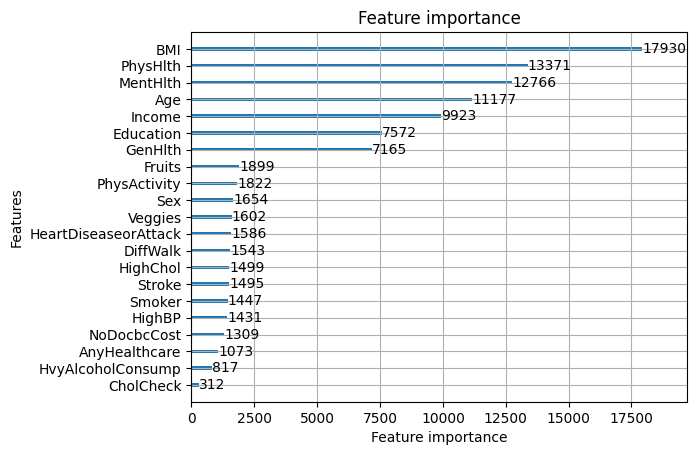

In [20]:
lgbm_tuned = LGBMClassifier(**best_params).fit(X_train,y_train)
lightgbm.plot_importance(lgbm_tuned)

In [21]:
models = [#DecisionTreeClassifier(),RandomForestClassifier(),SVC(),
          LogisticRegression(),XGBClassifier(),LGBMClassifier(),LGBMClassifier(**best_params)]
scoring = ['accuracy','f1','precision','recall']
models_columns = ['Name','fit_time','test_accuracy','train_accuracy',
                  'test_f1','train_f1','test_precision','train_precision',
                 'test_recall','train_recall']
models_chart = pd.DataFrame(columns = models_columns)

row_index = 0
for model in models:
    model_name = model.__class__.__name__
    models_chart.loc[row_index,'Name'] = model_name
    
    cv_results = cross_validate(model,X_train,y_train,cv =3,scoring = scoring,return_train_score = True,n_jobs=-1)
    models_chart.loc[row_index,'fit_time'] = cv_results['fit_time'].mean()
    models_chart.loc[row_index,'test_accuracy'] = cv_results['test_accuracy'].mean()
    models_chart.loc[row_index,'train_accuracy'] = cv_results['train_accuracy'].mean()
    models_chart.loc[row_index,'test_f1'] = cv_results[ 'test_f1'].mean()
    models_chart.loc[row_index,'train_f1'] = cv_results['train_f1'].mean()
    models_chart.loc[row_index,'test_precision'] = cv_results['test_precision'].mean()
    models_chart.loc[row_index,'train_precision'] = cv_results['train_precision'].mean()
    models_chart.loc[row_index,'test_recall'] = cv_results['test_recall'].mean()
    models_chart.loc[row_index,'train_recall'] = cv_results['train_recall'].mean()
    
    row_index +=1

models_chart.sort_values(by='test_accuracy',ascending = False)

,Name,fit_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
1,XGBClassifier,22.7,0.898,0.93,0.872,0.926,0.965,0.964,0.834,0.892
3,LGBMClassifier,22.5,0.898,0.946,0.873,0.943,0.963,0.978,0.836,0.911
2,LGBMClassifier,2.35,0.895,0.925,0.868,0.921,0.961,0.955,0.831,0.889
0,LogisticRegression,2.09,0.75,0.75,0.757,0.757,0.736,0.736,0.779,0.78


In [22]:
# Stacking
# probabilities of estimation on train dataset
train_prediction1_proba = lgbm.predict_proba(X_train)[:, 1]
train_prediction2_proba = xgb.predict_proba(X_train)[:, 1]
train_prediction3_proba = lr.predict_proba(X_train)[:, 1]

# probabilities of estimation on test dataset
test_prediction1_proba = lgbm.predict_proba(X_test)[:, 1]
test_prediction2_proba = xgb.predict_proba(X_test)[:, 1]
test_prediction3_proba = lr.predict_proba(X_test)[:, 1]

# stack the probabilities on train and the probabilities on test
train_stack = np.vstack([[train_prediction1_proba], 
                         [train_prediction2_proba], 
                         [train_prediction3_proba]]).T

test_stack = np.vstack([[test_prediction1_proba], 
                        [test_prediction2_proba], 
                        [test_prediction3_proba]]).T

In [23]:
lgbm_final = LGBMClassifier().fit(X_train, y_train)
lgbm_final.score(X_train, y_train), lgbm_final.score(X_test, y_test)

(0.919060945653635, 0.8661305581835383)

In [24]:
# Use lgbm as second level model
lgbm_final = lgbm_tuned.fit(train_stack, y_train)
lgbm_final.score(train_stack, y_train), lgbm_final.score(test_stack, y_test)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=1.7169730606852716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7169730606852716
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.000254776765891168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000254776765891168
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


(0.9245267454507681, 0.8656575212866604)

## Feature Engineering

Lift(Beer→Diaper) = (Confidence (Beer→Diaper))/(Support (Diaper)) \
what we replace to equals: \
lift(feature -> diabetes) = confidence(feature -> diabetes)/support(diabetes) \
confidence (feature -> diabetes) equals (cases containing both feature and diabetes)/(cases containing only feature)

In [25]:
selected_columns = ['HighBP', 'HighChol', 'CholCheck', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost','Sex']
sup_diabetes = np.mean(data['Diabetes_binary'])

for col in selected_columns:
    confidence = len(data[(data['Diabetes_binary'] == 1.0) & (data[col] == 1.0)])/len(data[col] == 1.0)
    lift = confidence/sup_diabetes
    print('Lift of',col,'is:',lift)

Lift of HighBP is: 0.7526735698523171
Lift of HighChol is: 0.6701182594918803
Lift of CholCheck is: 0.9931816895829798
Lift of Smoker is: 0.5182198834380128
Lift of Stroke is: 0.09245742092457422
Lift of HeartDiseaseorAttack is: 0.22288236292649807
Lift of PhysActivity is: 0.6305381089797998
Lift of Fruits is: 0.5854410682962713
Lift of Veggies is: 0.7564080801222204
Lift of HvyAlcoholConsump is: 0.023538731398178015
Lift of AnyHealthcare is: 0.9597691393651333
Lift of NoDocbcCost is: 0.10586770780286313
Lift of Sex is: 0.47912069258190465


According to the lift scores, no feature significantly affects diabetes positively. We could consider removing NoDocbcCost based on heatmap, feature importance of model, and lift.